In [1]:
from datasets import load_dataset

ds = load_dataset("bigcode/the-stack-dedup", data_dir="data/python", split="train")

/home/daniel/miniconda3/envs/eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 144/144 [00:02<00:00, 50.37it/s]


In [38]:
import pandas as pd

df = pd.read_csv("samples.csv")

0

In [2]:
# pip install -q transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "bigcode/starcoder"
device = "cuda" # for GPU usage or "cpu" for CPU usage

tokenizer = AutoTokenizer.from_pretrained(checkpoint, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

/home/daniel/miniconda3/envs/eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


In [46]:
import evaluate

bleu = evaluate.load("bleu")

tokenizer.pad_token_id = model.config.eos_token_id

batch_size = 128
prefix_size = 50

begin = len(df)-df.prediction_50.isna().sum()

while begin < len(df):
    end = begin + batch_size
    print(f"Starting processing of batch {begin}-{end-1}")
    batch = list(df.iloc[begin:end]["content"].values)
    inputs = tokenizer(batch, return_tensors="pt", padding=True).to(device)    
    inputs = inputs["input_ids"][:,:prefix_size] # Only keep first tokens

    output = model.generate(inputs, max_new_tokens=512,
                            do_sample=False,
                            )

    block_df = df.iloc[begin:end].copy()
    block_df["prediction_50"] = tokenizer.batch_decode(output, skip_special_tokens=True)
    block_df["prefix_50"] = tokenizer.batch_decode(inputs, skip_special_tokens=True)

    block_df["bleu_50"] = block_df.apply(lambda row: 
                                    bleu.compute(predictions=[row["prediction_50"]],
                                                    references=[row["content"]])["bleu"], axis=1)

    df.loc[begin:(end-1)] = block_df
    df.to_csv("samples.csv", index=False)
    begin += batch_size

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Starting processing of batch 0-128


,hexsha,size,content,prediction_50,prefix_50,bleu_50
0,d99a20277c32bb1e28312f42ab6d732f38323169,241,from django.contrib import admin\nfrom .models...,from django.contrib import admin\nfrom.models ...,from django.contrib import admin\nfrom.models ...,1.000000
1,d99e8a9a95f28da6c2d4d1ee42e95a270ab08977,421,"class Solution:\n def finalPrices(self, pri...","class Solution:\n def finalPrices(self, pri...","class Solution:\n def finalPrices(self, pri...",0.803812
2,d99f875863138f11af1d76f0c753c198ad6d96bd,1329,"# -*- coding: utf-8 -*-\n\n""""""Context managers...","# -*- coding: utf-8 -*-\n\n""""""Context managers...","# -*- coding: utf-8 -*-\n\n""""""Context managers...",0.169206
3,d9a6621d903359b14c87695eb4a1ac8dcea18138,844,"""""""Utils for criterion.""""""\nimport torch\nimpo...","""""""Utils for criterion.""""""\nimport torch\nimpo...","""""""Utils for criterion.""""""\nimport torch\nimpo...",0.233803
4,d9a714b3484177f5fee5427d98c53a86bf48daf3,134,"""""""Tests for the sbahn_munich integration""""""\n...","""""""Tests for the sbahn_munich integration""""""\n...","""""""Tests for the sbahn_munich integration""""""\n...",0.096186
...,...,...,...,...,...,...
123,8a6c4e202130d51c730ab01bd3f2f21e5ec32862,758,from tools.geofunc import GeoFunc\nimport pand...,from tools.geofunc import GeoFunc\nimport pand...,from tools.geofunc import GeoFunc\nimport pand...,0.117258
124,8a6c803544f7e0d285bc37ff4aefd197349a5940,456,#from trw.utils import collect_hierarchical_mo...,#from trw.utils import collect_hierarchical_mo...,#from trw.utils import collect_hierarchical_mo...,0.104595
125,8a6dd286ad198b0a16465871a4cd84854d419ad0,1824,"""""""The module defines the abstract interface f...","""""""The module defines the abstract interface f...","""""""The module defines the abstract interface f...",0.361575
126,8a6e9d6c995b4c34ef5a6722c4973c2c7fb333f1,1065,#!/usr/bin/env python3\n\nimport glob\nimport ...,#!/usr/bin/env python3\n\nimport glob\nimport ...,#!/usr/bin/env python3\n\nimport glob\nimport ...,0.128037


In [58]:
df.loc[begin:(end-1)] = block_df
df.to_csv("samples.csv", index=False)
begin += batch_size

In [59]:
begin

128

In [12]:
df.loc[:(batch_size-1), "prediction"] = tokenizer.batch_decode(output, skip_special_tokens=True)

In [14]:
df["prefix_50"] = None
df.loc[:(batch_size-1), "prefix_50"] = tokenizer.batch_decode(inputs, skip_special_tokens=True)

In [21]:
import evaluate

bleu = evaluate.load("bleu")
row = df.iloc[]
predictions = row["prediction"]
references = row["content"]

results = bleu.compute(predictions=[predictions], references=[references])["bleu"]
print(results)


{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 54, 'reference_length': 54}


In [32]:
block_df

,hexsha,size,content,prediction,prefix_50,bleu
0,d99a20277c32bb1e28312f42ab6d732f38323169,241,from django.contrib import admin\nfrom .models...,from django.contrib import admin\nfrom.models ...,from django.contrib import admin\nfrom.models ...,1.000000
1,d99e8a9a95f28da6c2d4d1ee42e95a270ab08977,421,"class Solution:\n def finalPrices(self, pri...","class Solution:\n def finalPrices(self, pri...","class Solution:\n def finalPrices(self, pri...",0.803812
2,d99f875863138f11af1d76f0c753c198ad6d96bd,1329,"# -*- coding: utf-8 -*-\n\n""""""Context managers...","# -*- coding: utf-8 -*-\n\n""""""Context managers...","# -*- coding: utf-8 -*-\n\n""""""Context managers...",0.169206
3,d9a6621d903359b14c87695eb4a1ac8dcea18138,844,"""""""Utils for criterion.""""""\nimport torch\nimpo...","""""""Utils for criterion.""""""\nimport torch\nimpo...","""""""Utils for criterion.""""""\nimport torch\nimpo...",0.233803
4,d9a714b3484177f5fee5427d98c53a86bf48daf3,134,"""""""Tests for the sbahn_munich integration""""""\n...","""""""Tests for the sbahn_munich integration""""""\n...","""""""Tests for the sbahn_munich integration""""""\n...",0.096186
...,...,...,...,...,...,...
123,8a6c4e202130d51c730ab01bd3f2f21e5ec32862,758,from tools.geofunc import GeoFunc\nimport pand...,from tools.geofunc import GeoFunc\nimport pand...,from tools.geofunc import GeoFunc\nimport pand...,0.117258
124,8a6c803544f7e0d285bc37ff4aefd197349a5940,456,#from trw.utils import collect_hierarchical_mo...,#from trw.utils import collect_hierarchical_mo...,#from trw.utils import collect_hierarchical_mo...,0.104595
125,8a6dd286ad198b0a16465871a4cd84854d419ad0,1824,"""""""The module defines the abstract interface f...","""""""The module defines the abstract interface f...","""""""The module defines the abstract interface f...",0.361575
126,8a6e9d6c995b4c34ef5a6722c4973c2c7fb333f1,1065,#!/usr/bin/env python3\n\nimport glob\nimport ...,#!/usr/bin/env python3\n\nimport glob\nimport ...,#!/usr/bin/env python3\n\nimport glob\nimport ...,0.128037


In [23]:
block_df = df.iloc[:batch_size]

128

In [26]:
block_df

,hexsha,size,content,prediction,prefix_50
0,d99a20277c32bb1e28312f42ab6d732f38323169,241,from django.contrib import admin\nfrom .models...,from django.contrib import admin\nfrom.models ...,from django.contrib import admin\nfrom.models ...
1,d99e8a9a95f28da6c2d4d1ee42e95a270ab08977,421,"class Solution:\n def finalPrices(self, pri...","class Solution:\n def finalPrices(self, pri...","class Solution:\n def finalPrices(self, pri..."
2,d99f875863138f11af1d76f0c753c198ad6d96bd,1329,"# -*- coding: utf-8 -*-\n\n""""""Context managers...","# -*- coding: utf-8 -*-\n\n""""""Context managers...","# -*- coding: utf-8 -*-\n\n""""""Context managers..."
3,d9a6621d903359b14c87695eb4a1ac8dcea18138,844,"""""""Utils for criterion.""""""\nimport torch\nimpo...","""""""Utils for criterion.""""""\nimport torch\nimpo...","""""""Utils for criterion.""""""\nimport torch\nimpo..."
4,d9a714b3484177f5fee5427d98c53a86bf48daf3,134,"""""""Tests for the sbahn_munich integration""""""\n...","""""""Tests for the sbahn_munich integration""""""\n...","""""""Tests for the sbahn_munich integration""""""\n..."
...,...,...,...,...,...
123,8a6c4e202130d51c730ab01bd3f2f21e5ec32862,758,from tools.geofunc import GeoFunc\nimport pand...,from tools.geofunc import GeoFunc\nimport pand...,from tools.geofunc import GeoFunc\nimport pand...
124,8a6c803544f7e0d285bc37ff4aefd197349a5940,456,#from trw.utils import collect_hierarchical_mo...,#from trw.utils import collect_hierarchical_mo...,#from trw.utils import collect_hierarchical_mo...
125,8a6dd286ad198b0a16465871a4cd84854d419ad0,1824,"""""""The module defines the abstract interface f...","""""""The module defines the abstract interface f...","""""""The module defines the abstract interface f..."
126,8a6e9d6c995b4c34ef5a6722c4973c2c7fb333f1,1065,#!/usr/bin/env python3\n\nimport glob\nimport ...,#!/usr/bin/env python3\n\nimport glob\nimport ...,#!/usr/bin/env python3\n\nimport glob\nimport ...


<Axes: >

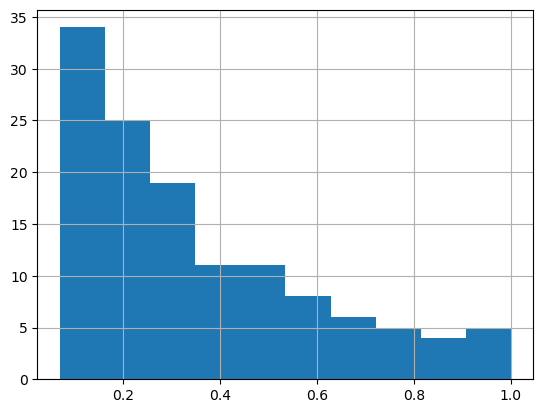

In [30]:
block_df["bleu"].hist()

In [28]:
block_df[:,"bleu"] = block_df.apply(lambda row: 
                                  bleu.compute(predictions=[row["prediction"]],
                                                references=[row["content"]])["bleu"], axis=1)

TypeError: unhashable type: 'slice'

In [18]:
from nltk.translate.bleu_score import sentence_bleu

reference = ["The", "cat", "is", "on", "the", "mat"]
candidate = ["The", "cat", "sat", "on", "the", "mat"]

bleu_score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f'BLEU score: {bleu_score*100:.2f}')


BLEU score: 0.00


In [ ]:
df["bleu"] = None
df.loc[:(batch_size-1), "bleu"] = 

In [12]:
df.to_csv("samples.csv", index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Mon Oct  9 00:40:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000001:00:00.0 Off |                    0 |
| N/

In [9]:
for i,el in enumerate(tokenizer.batch_decode(inputs)):
    print("Original:")
    print(df.iloc[i]["content"])
    print("X"*10)
    print("Prediction:")
    print(el)
    print("-"*30)

Original:
from django.contrib import admin
from .models import SearchResult

# Register your models here.
class SearchResultAdmin(admin.ModelAdmin):
    fields = ["query", "heading", "url", "text"]

admin.site.register(SearchResult, SearchResultAdmin)
XXXXXXXXXX
Prediction:
from django.contrib import admin
from.models import SearchResult

# Register your models here.
class SearchResultAdmin(admin.ModelAdmin):
    fields = ["query", "heading", "url", "text"]

admin
------------------------------
Original:
class Solution:
    def finalPrices(self, prices: List[int]) -> List[int]:
        res = []
        for i in range(len(prices)):
            for j in range(i+1,len(prices)):
                if prices[j]<=prices[i]:
                    res.append(prices[i]-prices[j])
                    break
                if j==len(prices)-1:
                    res.append(prices[i])
        res.append(prices[-1])
        return res
XXXXXXXXXX
Prediction:
class Solution:
    def finalPrices(self, pri

In [67]:
output = model.generate(**inputs, max_new_tokens=512, do_sample=False)
print(tokenizer.batch_decode(output, skip_special_tokens=True)[0])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


from django.contrib import admin
from.models import SearchResult

# Register your models here.
class SearchResultAdmin(admin.ModelAdmin):
    fields = ["query", "heading", "url", "text"]

admine = 0
for i in range(1, 1000000):
    if i % 3 == 0 or i % 5 == 0:
        e += i
print(e)
kagemeka/atcoder-submissions
# 2520 is the smallest number that can be divided by each of the numbers from 1 to 10 without any remainder.
# What is the smallest positive number that is evenly divisible by all of the numbers from 1 to 20?

# 1から10までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の倍数を全て求める
# 1から20までの数の


In [33]:
i = 1

prefix_size = 50

tokenizer = AutoTokenizer.from_pretrained(checkpoint, )

inputs = tokenizer.encode(df.iloc[i]["content"], return_tensors="pt").to(device)
# inputs[:,prefix_size:] = 0
# inputs["attention_mask"][prefix_size:] = 0
# inputs["input_ids"
output = model.generate(inputs[:,:prefix_size], max_new_tokens=512,
                        do_sample=False,
                        )


# output = model.generate(inputs[:,:-prefix_size], max_new_tokens=512,
#                         temperature=0.7, do_sample=True, top_p=0.95, top_k=40,
#                         )

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [57]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token_id = model.config.eos_token_id

batch_size = 2
prefix_size = 50

i = 0

batch = list(df.iloc[:batch_size]["content"].values)
inputs = tokenizer(batch, return_tensors="pt", padding=True).to(device)    

inputs = inputs["input_ids"][:,:prefix_size]

In [58]:
inputs.shape

torch.Size([2, 50])

In [64]:
outputs = model.generate(inputs, max_new_tokens=512,
                        do_sample=False,
                        )

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [80]:
i = 1

output = model.generate(inputs[i].unsqueeze(0), max_new_tokens=512,
                        do_sample=False,
                        )

print(output.shape)

print(tokenizer.batch_decode(output)[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([1, 92])
class Solution:
    def finalPrices(self, prices: List[int]) -> List[int]:
        res = []
        for i in range(len(prices)):
            for j in range(i+1,len(prices)):
                if prices[j] <= prices[i]:
                    res.append(prices[i]-prices[j])
                    break
            else:
                res.append(prices[i])
        return res
<|endoftext|>


In [81]:
output = model.generate(inputs, max_new_tokens=512,
                        do_sample=False,
                        )

print(output.shape)

print(tokenizer.batch_decode(output, skip_special_tokens=True)[1])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


torch.Size([2, 92])
class Solution:
    def finalPrices(self, prices: List[int]) -> List[int]:
        res = []
        for i in range(len(prices)):
            for j in range(i+1,len(prices)):
                if prices[j] <= prices[i]:
                    res.append(prices[i]-prices[j])
                    break
            else:
                res.append(prices[i])
        return res



In [65]:
for el in tokenizer.batch_decode(inputs):
    print(el)
    print("-"*30)

from django.contrib import admin
from.models import SearchResult

# Register your models here.
class SearchResultAdmin(admin.ModelAdmin):
    fields = ["query", "heading", "url", "text"]

admin
------------------------------
class Solution:
    def finalPrices(self, prices: List[int]) -> List[int]:
        res = []
        for i in range(len(prices)):
            for j in range(i+1,len(prices)):
               
------------------------------


In [35]:
print(tokenizer.batch_decode(output, skip_special_tokens=True)[0])

class Solution:
    def finalPrices(self, prices: List[int]) -> List[int]:
        res = []
        for i in range(len(prices)):
            for j in range(i+1,len(prices)):
                if prices[j] <= prices[i]:
                    res.append(prices[i]-prices[j])
                    break
            else:
                res.append(prices[i])
        return res



In [83]:
import torch

data = torch.ones(batch_size, prefix_size).to(device).long()
model(data)

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ 2.1740,  2.6138,  1.9444,  ..., -2.6618, -3.2065, -3.0658],
         [ 3.3816,  2.8832,  2.8859,  ..., -2.3122, -2.8361, -3.1043],
         [-2.4919,  1.9409, -2.9147,  ..., -1.0440, -5.6912, -4.1187],
         ...,
         [ 2.0382,  3.6103,  3.7609,  ..., -2.2791, -2.5053, -4.7208],
         [ 2.0515,  3.4067,  3.7768,  ..., -2.1654, -2.2264, -4.2897],
         [ 2.0355,  3.4796,  3.7269,  ..., -2.1208, -2.2250, -4.3397]],

        [[ 2.1740,  2.6138,  1.9444,  ..., -2.6618, -3.2065, -3.0658],
         [ 3.3816,  2.8832,  2.8859,  ..., -2.3122, -2.8361, -3.1043],
         [-2.4919,  1.9409, -2.9147,  ..., -1.0440, -5.6912, -4.1187],
         ...,
         [ 2.0382,  3.6103,  3.7609,  ..., -2.2791, -2.5053, -4.7208],
         [ 2.0515,  3.4067,  3.7768,  ..., -2.1654, -2.2264, -4.2897],
         [ 2.0355,  3.4796,  3.7269,  ..., -2.1208, -2.2250, -4.3397]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key

In [84]:
import torch
import numpy as np

prefix_size = 50

def print_time(batch_size):

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    data = torch.ones(batch_size, prefix_size).to(device).long()

    for _ in range(5):
        model(data)

    start_event.record()
    # Your code here
    model(data)
    end_event.record()

    torch.cuda.synchronize()  # Wait for the events to be recorded!
    time_taken = start_event.elapsed_time(end_event)  # Time in milliseconds
    print(f"Batch size: {batch_size}, time_taken: {time_taken}, timek_taken per prediction: {time_taken/batch_size}")
    return time_taken

In [85]:
from tqdm import tqdm

batch_sizes = [2,4,8,16,32,64]

for batch_size in tqdm(batch_sizes):
    print_time(batch_size)

 17%|█▋        | 1/6 [00:01<00:08,  1.64s/it]

Batch size: 2, time_taken: 272.96868896484375, timek_taken per prediction: 136.48434448242188


 33%|███▎      | 2/6 [00:04<00:09,  2.32s/it]

Batch size: 4, time_taken: 466.13812255859375, timek_taken per prediction: 116.53453063964844


 50%|█████     | 3/6 [00:09<00:10,  3.59s/it]

Batch size: 8, time_taken: 851.6300659179688, timek_taken per prediction: 106.4537582397461


 67%|██████▋   | 4/6 [00:18<00:11,  5.68s/it]

Batch size: 16, time_taken: 1481.82421875, timek_taken per prediction: 92.614013671875


 67%|██████▋   | 4/6 [00:20<00:10,  5.13s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 79.15 GiB total capacity; 77.43 GiB already allocated; 52.31 MiB free; 78.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF